In [65]:
%pip install keras-cv --quiet
%pip install keras-core --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(name='caltech_birds2011', with_info=True)

In [11]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

train, val, test = tfds.load('caltech_birds2011',
                             split=['train', 'test[:50%]', 'test[50%:]'])

In [94]:
import tensorflow as tf
from tensorflow import keras

preprocessing_layers = keras.Sequential([
    keras.layers.Resizing(width=224, height=224),
    keras.layers.Lambda(keras.applications.vgg19.preprocess_input)
])

def preprocess(instance):
    return(preprocessing_layers(instance['image']),
           (instance['label'], instance['bbox']))
def label_preprocess(instance):
    return(preprocessing_layers(instance['image']),
           instance['label'])
def bbox_preprocess(instance):
    return(preprocessing_layers(instance['image']),
           instance['bbox'])

train_ds = train.map(preprocess).shuffle(buffer_size=1024).batch(32).prefetch(1)
val_ds = val.map(preprocess).batch(32).prefetch(1)
test_ds = test.map(preprocess).batch(32).prefetch(1)

label_train_ds = train.map(label_preprocess).shuffle(buffer_size=1024).batch(32).prefetch(1)
label_val_ds = val.map(label_preprocess).batch(32).prefetch(1)
label_test_ds = test.map(label_preprocess).batch(32).prefetch(1)

bbox_train_ds = train.map(bbox_preprocess).shuffle(buffer_size=1024).batch(32).prefetch(1)
bbox_val_ds = val.map(bbox_preprocess).batch(32).prefetch(1)
bbox_test_ds = test.map(bbox_preprocess).batch(32).prefetch(1)

example = train.map(preprocess).batch(32).prefetch(1)

In [67]:
import keras_cv
def iou(y_true, y_pred):
    return keras_cv.bounding_box.compute_iou(
      y_true,
      y_pred,
      bounding_box_format='yxyx',
  )


In [ ]:
data_augumentation = keras.Sequential([
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomZoom(0.2)
])
base_model = keras.applications.VGG19(include_top=False)

for layer in base_model.layers:
    layer.trainable = False

inputs = keras.layers.Input(shape=(224,224,3))
aug = data_augumentation(inputs)
label_base = base_model(aug)
label_flatten = keras.layers.Flatten()(label_base)
label_dropout = keras.layers.Dropout(0.5)(label_flatten)
label_out = keras.layers.Dense(200, 'softmax', name='label')(label_dropout)

bbox_base = base_model(inputs)
bbox_flatten = keras.layers.Flatten()(bbox_base)
bbox_dropout = keras.layers.Dropout(0.5)(bbox_flatten)
bbox_out = keras.layers.Dense(4, 'sigmoid', name='bbox')(dropout)

label_model = keras.Model(inputs=inputs, outputs=label_out)
bbox_model = keras.Model(inputs=inputs, outputs=bbox_out)

In [ ]:
optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=1e-3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              restore_best_weights=True)
label_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics='accuracy'
)
label_history = label_model.fit(label_train_ds, validation_data=label_val_ds,
                    epochs=50, callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 57s 271ms/step - loss: 797.4282 - accuracy: 0.8685 - val_loss: 20366.0234 - val_accuracy: 0.2641
Epoch 2/50
188/188 [==============================] - 55s 262ms/step - loss: 534.0078 - accuracy: 0.8951 - val_loss: 19368.3984 - val_accuracy: 0.2758
Epoch 3/50
188/188 [==============================] - 60s 293ms/step - loss: 405.4570 - accuracy: 0.9121 - val_loss: 18931.2676 - val_accuracy: 0.2824
Epoch 4/50
188/188 [==============================] - 57s 276ms/step - loss: 342.8167 - accuracy: 0.9248 - val_loss: 18903.7676 - val_accuracy: 0.2834
Epoch 5/50
188/188 [==============================] - 55s 266ms/step - loss: 357.3471 - accuracy: 0.9256 - val_loss: 18704.0156 - val_accuracy: 0.2893
Epoch 6/50
188/188 [==============================] - 55s 263ms/step - loss: 280.2844 - accuracy: 0.9293 - val_loss: 18425.7832 - val_accuracy: 0.2931
Epoch 7/50
188/188 [==============================] - 55s 269ms/step - loss: 248.3822 - accura

In [97]:
optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=1e-3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              restore_best_weights=True)
bbox_model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=iou
)
bbox_history = bbox_model.fit(bbox_train_ds, validation_data=bbox_val_ds,
                    epochs=50, callbacks=[early_stopping])

Epoch 1/50


KeyboardInterrupt: 

In [92]:
optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=1e-3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              restore_best_weights=True)
model.compile(
    loss=['sparse_categorical_crossentropy', 'mse'],
    loss_weights=[.8, .2],
    optimizer=optimizer,
    metrics={'label': 'accuracy', 'bbox':iou}
)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=50, callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 61s 291ms/step - loss: 3.8711 - label_loss: 4.8287 - bbox_loss: 0.0406 - label_accuracy: 0.0689 - bbox_iou: 0.2673 - val_loss: 4.2815 - val_label_loss: 5.3429 - val_bbox_loss: 0.0356 - val_label_accuracy: 0.0366 - val_bbox_iou: 0.3805
Epoch 2/50
188/188 [==============================] - 59s 288ms/step - loss: 3.6118 - label_loss: 4.5058 - bbox_loss: 0.0358 - label_accuracy: 0.1069 - bbox_iou: 0.3427 - val_loss: 4.3139 - val_label_loss: 5.3828 - val_bbox_loss: 0.0385 - val_label_accuracy: 0.0535 - val_bbox_iou: 0.4016
Epoch 3/50
188/188 [==============================] - 59s 290ms/step - loss: 3.3326 - label_loss: 4.1572 - bbox_loss: 0.0341 - label_accuracy: 0.1438 - bbox_iou: 0.3861 - val_loss: 4.2837 - val_label_loss: 5.3445 - val_bbox_loss: 0.0408 - val_label_accuracy: 0.0687 - val_bbox_iou: 0.4030
Epoch 4/50
188/188 [==============================] - 55s 267ms/step - loss: 3.0344 - label_loss: 3.7846 - bbox_loss: 0.0339 - label_

In [77]:
model.evaluate(test_ds)

91/91 [==============================] - 18s 195ms/step - loss: 2.0092 - label_out_loss: 2.4967 - bbox_out_loss: 0.0589 - label_out_accuracy: 0.4401 - bbox_out_iou: 0.3381


[2.009158134460449,
 2.496713399887085,
 0.058939505368471146,
 0.440110445022583,
 0.3381214737892151]

In [ ]:
model.save('caltech_birds.keras')

In [72]:
import tensorflow as tf
import keras_cv
def get_boxes (images, out):
    bbox = out[1] * 224
    classes = out[0]
    return {
        'boxes': tf.reshape(bbox, shape=(-1,1,4)),
        'classes': tf.reshape(classes, shape=(-1,1))
    }
images = example.map(lambda image,_: image)
bboxes = example.map(get_boxes)

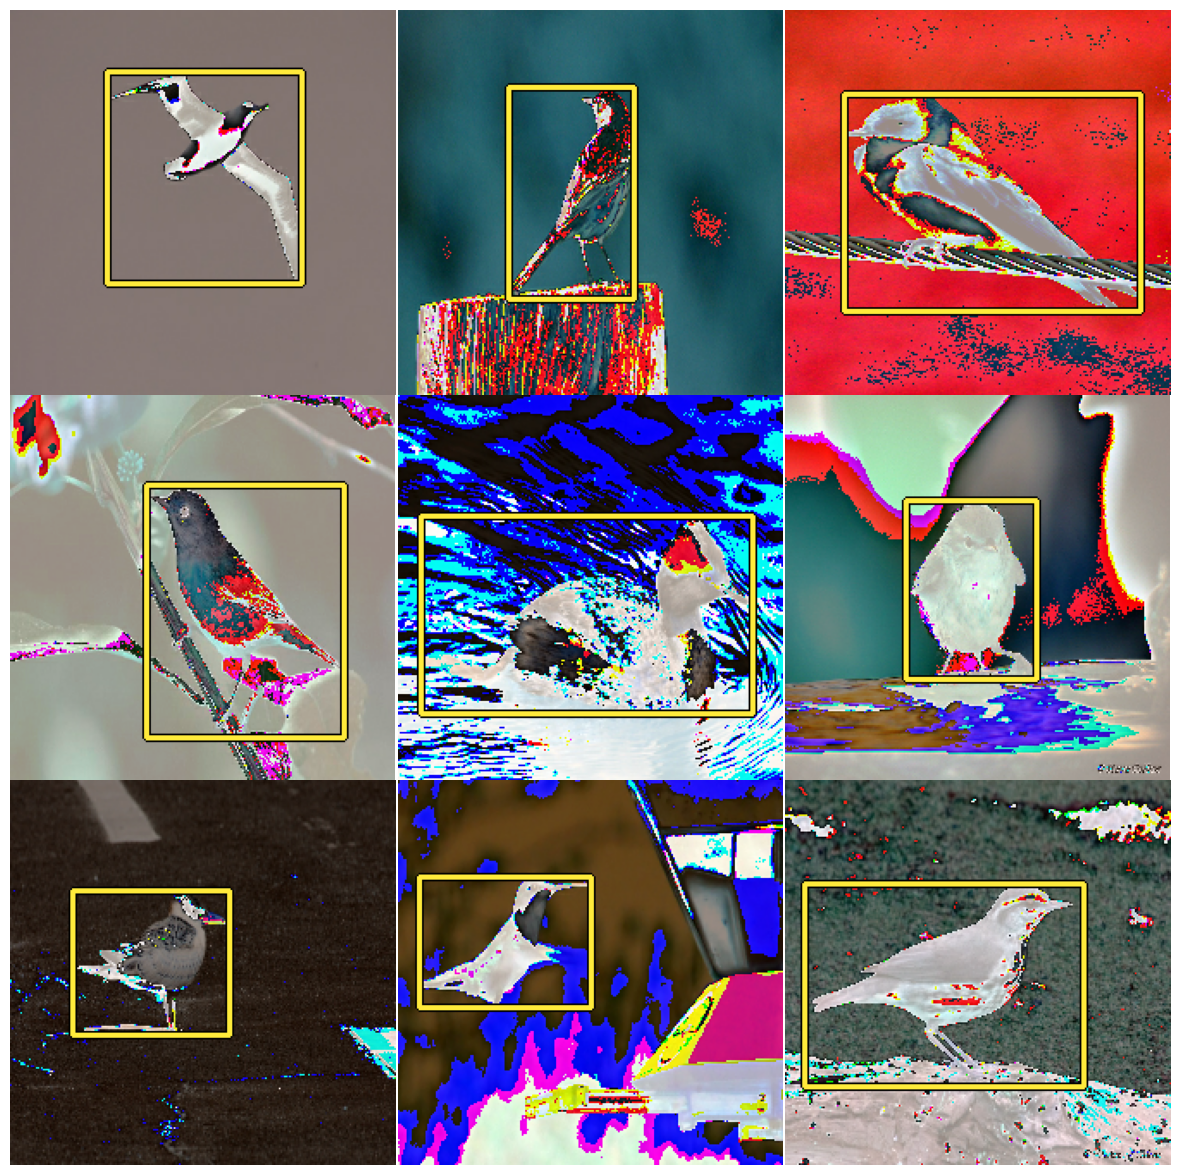

In [73]:
for image, bbox in zip(images.take(1), bboxes.take(1)):
    keras_cv.visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=3,
    cols=3,
    y_pred=bbox,
    scale=5,
    font_scale=0.7,
    bounding_box_format="yxyx",
)